In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from main import infer  # or whatever you're importing
#imshow function
def imshow(title = "Image", image = None, size = 10):
    w= image.shape[0]
    h=image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()


In [ ]:
#Function to break an image into lines so that it simple htr can read it well
import cv2
import numpy as np

def segment_lines(img, y_gap_threshold=10, pad=5, expected_lines=5):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarize + invert
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours of text blobs
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get bounding boxes and sort by top Y
    boxes = [cv2.boundingRect(c) for c in contours]
    boxes = sorted(boxes, key=lambda b: b[1])

    # Group boxes into lines
    lines = []
    current_line = []

    for box in boxes:
        x, y, w, h = box
        if not current_line:
            current_line.append(box)
        else:
            _, last_y, _, last_h = current_line[-1]
            if abs(y - last_y) < y_gap_threshold or abs((y + h) - (last_y + last_h)) < y_gap_threshold:
                current_line.append(box)
            else:
                lines.append(current_line)
                current_line = [box]
    if current_line:
        lines.append(current_line)

    # Extract image region for each line group
    line_imgs = []
    for group in lines:
        xs = [b[0] for b in group]
        ys = [b[1] for b in group]
        ws = [b[0] + b[2] for b in group]
        hs = [b[1] + b[3] for b in group]

        x1 = max(min(xs) - pad, 0)
        y1 = max(min(ys) - pad, 0)
        x2 = min(max(ws) + pad, img.shape[1])
        y2 = min(max(hs) + pad, img.shape[0])

        if (y2 - y1) > 10:
            line_imgs.append(img[y1:y2, x1:x2])

    # Fail-safe: enforce exactly 5 lines. If less than 5 are found, it will trigger an error
    if len(line_imgs) > expected_lines:
        line_imgs = line_imgs[-expected_lines:]
    elif len(line_imgs) < expected_lines:
        raise ValueError(f"Expected {expected_lines} lines, but found {len(line_imgs)}.")

    return line_imgs






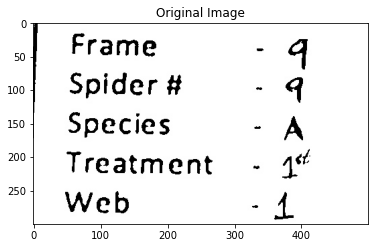

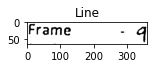

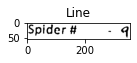

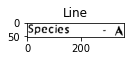

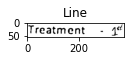

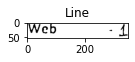

In [3]:
#Import the processed image from the TargetingText notebook
img = cv2.imread("C:\Files\Araneus diadematus\Processed Images\processed.jpg", cv2.IMREAD_GRAYSCALE)
imshow("Original Image", img)
lines = segment_lines(img) #returns a list of images of each line
for i in lines:
    linenum = 1
    imshow("Line", i, size = 12)
    linenum += 1

In [17]:
import tensorflow.compat.v1 as tf
import cv2
import numpy as np
from typing import List
from model import Model, DecoderType
from dataloader_iam import Batch
from preprocessor import Preprocessor

# Disable TF v2 behavior
tf.disable_v2_behavior()
tf.reset_default_graph()
# Character list (same as used during training)
char_list = list("!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ")

# Global session and model
sess = tf.Session()
model = Model(char_list=char_list, decoder_type=DecoderType.BestPath, must_restore=True, dump=False)
preprocessor = Preprocessor(img_size=(128, 32))  # or whatever config matches your training


Python: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Tensorflow: 1.15.0


Exception: No saved model found in: ../model/

In [12]:
# Simple HTR inference for list of images using existing classes
import tensorflow.compat.v1 as tf
import cv2
import numpy as np
from typing import List

# Disable TensorFlow v2 behavior
tf.disable_v2_behavior()

# Import existing classes from the HTR project
from model import Model, DecoderType
from dataloader_iam import Batch
from preprocessor import Preprocessor

def process_image_list_htr(images: List[np.ndarray], 
                          char_list: List[str] = None) -> List[str]:
    """
    Process a list of images using the existing HTR classes.
    
    Args:
        images: List of numpy arrays (images from cv2.imread, etc.)
        char_list: List of characters the model recognizes
    
    Returns:
        List of recognized text strings
    """
    tf.reset_default_graph()
    # Default character list if not provided
    if char_list is None:
        # This should match what your model was trained on
        char_list = list("!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ")
    
    # Initialize preprocessor (with default parameters - adjust if needed)
    try:
        # HTR models typically use (128, 32) as image size
        preprocessor = Preprocessor(img_size=(128, 32))
    except Exception as e:
        print(f"Error initializing Preprocessor: {e}")
        print("You may need to check the Preprocessor class parameters in preprocessor.py")
        return []
    
    # Preprocess all images
    processed_images = []
    for i, img in enumerate(images):
        try:
            # The preprocessor method might be named differently
            # Common names: processImg, process_img, preprocess, etc.
            if hasattr(preprocessor, 'processImg'):
                processed_img = preprocessor.processImg(img)
            elif hasattr(preprocessor, 'process_img'):
                processed_img = preprocessor.process_img(img)
            elif hasattr(preprocessor, 'preprocess'):
                processed_img = preprocessor.preprocess(img)
            else:
                # If we can't find the method, do basic preprocessing
                print("Using basic preprocessing - you may need to adjust this")
                processed_img = basic_preprocess(img)
            
            processed_images.append(processed_img)
            
        except Exception as e:
            print(f"Error preprocessing image {i}: {e}")
            continue
    
    if not processed_images:
        print("No valid images to process")
        return []
    
    # Create batch with processed images
    batch = Batch(processed_images, [""] * len(processed_images), batch_size=len(processed_images))
    
    # Initialize model
    try:
        model = Model(char_list=char_list, 
                      decoder_type=DecoderType.BestPath, 
                      must_restore=True, 
                      dump=False)
        
        # Run inference
        recognized_texts, _ = model.infer_batch(batch)
        return recognized_texts
        
    except Exception as e:
        print(f"Error during model initialization or inference: {e}")
        return [""] * len(processed_images)


In [15]:
char_list = list("!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ")
model = Model(char_list=char_list, 
                      decoder_type=DecoderType.BestPath, 
                      must_restore=True, 
                      dump=False)
results = process_image_list_htr(lines)

ValueError: in converted code:
    relative to c:\Users\adamain\.conda\envs\simplehtr\lib\site-packages\tensorflow_core\python:

    ops\rnn_cell_impl.py:1312 call
        cur_inp, new_state = cell(cur_inp, cur_state)
    ops\rnn_cell_impl.py:386 __call__
        self, inputs, state, scope=scope, *args, **kwargs)
    layers\base.py:548 __call__
        outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
    keras\engine\base_layer.py:824 __call__
        self._maybe_build(inputs)
    keras\engine\base_layer.py:2146 _maybe_build
        self.build(input_shapes)
    keras\utils\tf_utils.py:306 wrapper
        output_shape = fn(instance, input_shape)
    ops\rnn_cell_impl.py:958 build
        partitioner=maybe_partitioner)
    util\deprecation.py:324 new_func
        return func(*args, **kwargs)
    keras\engine\base_layer.py:1707 add_variable
        return self.add_weight(*args, **kwargs)
    layers\base.py:461 add_weight
        **kwargs)
    keras\engine\base_layer.py:529 add_weight
        aggregation=aggregation)
    training\tracking\base.py:712 _add_variable_with_custom_getter
        **kwargs_for_getter)
    ops\variable_scope.py:1500 get_variable
        aggregation=aggregation)
    ops\variable_scope.py:1243 get_variable
        aggregation=aggregation)
    ops\variable_scope.py:550 get_variable
        return custom_getter(**custom_getter_kwargs)
    ops\rnn_cell_impl.py:247 _rnn_get_variable
        variable = getter(*args, **kwargs)
    ops\variable_scope.py:519 _true_getter
        aggregation=aggregation)
    ops\variable_scope.py:868 _get_single_variable
        (err_msg, "".join(traceback.format_list(tb))))

    ValueError: Variable bidirectional_rnn/fw/multi_rnn_cell/cell_0/lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:
    
      File "c:\Users\adamain\.conda\envs\simplehtr\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
        self._traceback = tf_stack.extract_stack()
      File "c:\Users\adamain\.conda\envs\simplehtr\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
        op_def=op_def)
      File "c:\Users\adamain\.conda\envs\simplehtr\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
        attrs, op_def, compute_device)
      File "c:\Users\adamain\.conda\envs\simplehtr\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
        return func(*args, **kwargs)
      File "c:\Users\adamain\.conda\envs\simplehtr\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
        op_def=op_def)
    


In [13]:
# Usage examples for the HTR function

import cv2
import numpy as np
from typing import List

# Example 1: Process multiple image files
def process_image_files(image_paths: List[str]) -> List[str]:
    """Load images from file paths and process them"""
    images = []
    
    for path in image_paths:
        try:
            # Load image using OpenCV
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            if img is not None:
                images.append(img)
            else:
                print(f"Failed to load image: {path}")
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    if images:
        # Call your HTR function
        results = process_image_list_htr(images)
        return results
    return []

# Example 2: Process images with custom character set
def process_with_custom_chars(images: List[np.ndarray]) -> List[str]:
    """Process images with a custom character list"""
    # Define characters your model recognizes (adjust based on your trained model)
    custom_chars = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,!? ")
    
    results = process_image_list_htr(images, char_list=custom_chars)
    return results

# Example 3: Complete workflow with error handling
def complete_htr_workflow(image_paths: List[str]) -> dict:
    """Complete HTR workflow with detailed results"""
    results = {
        'successful': [],
        'failed': [],
        'recognized_text': []
    }
    
    for i, path in enumerate(image_paths):
        try:
            # Load image
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                results['failed'].append(f"Could not load: {path}")
                continue
            
            # Process single image (convert to list)
            text_results = process_image_list_htr([img])
            
            if text_results and text_results[0]:
                results['successful'].append(path)
                results['recognized_text'].append({
                    'file': path,
                    'text': text_results[0],
                    'confidence': 'N/A'  # Your function doesn't return confidence
                })
            else:
                results['failed'].append(f"No text recognized: {path}")
                
        except Exception as e:
            results['failed'].append(f"Error processing {path}: {str(e)}")
    
    return results

# Example 4: Basic preprocessing function (fallback)
def basic_preprocess(img: np.ndarray, target_size=(128, 32)) -> np.ndarray:
    """
    Basic preprocessing if the Preprocessor class methods aren't found
    This is a simplified version - adjust based on your model's needs
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize to target size
    img = cv2.resize(img, target_size)
    
    # Normalize pixel values
    img = img.astype(np.float32) / 255.0
    
    # Add batch dimension if needed
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=0)
    
    return img

# CORRECT Usage for your case - you already have numpy arrays:
def process_numpy_arrays(lines: List[np.ndarray]) -> List[str]:
    """
    Process numpy arrays directly - no need to load from files
    """
    try:
        # Call the HTR function directly with your numpy arrays
        results = process_image_list_htr(lines)
        return results
    except Exception as e:
        print(f"Error processing numpy arrays: {e}")
        return []

# Usage examples:
if __name__ == "__main__":
    # YOUR CASE: You already have numpy arrays in 'lines'
    # lines = [array1, array2, array3, array4, array5]  # Your 5 numpy arrays
    
    # Method 1: Direct processing (RECOMMENDED FOR YOU)
    results = process_image_list_htr(lines)
    for i, text in enumerate(results):
        print(f"Line {i+1}: '{text}'")
    
    # Method 2: With wrapper function
    results = process_numpy_arrays(lines)
    for i, text in enumerate(results):
        print(f"Line {i+1}: '{text}'")
    
    # ONLY use the file processing methods if you have file paths:
    # image_files = ["handwriting1.jpg", "handwriting2.png", "document1.jpg"]
    # results = process_image_files(image_files)  # This expects file paths, not arrays

Python: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Tensorflow: 1.15.0
Error during model initialization or inference: No saved model found in: ../model/
Line 1: ''
Line 2: ''
Line 3: ''
Line 4: ''
Line 5: ''
Python: 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
Tensorflow: 1.15.0
Error during model initialization or inference: No saved model found in: ../model/
Line 1: ''
Line 2: ''
Line 3: ''
Line 4: ''
Line 5: ''
